In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import csv
import os
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import openslide

from Detection.data_loader import *
from SlideRunner.dataAccess.database import Database
from matplotlib import cm
import pickle

import matplotlib as mpl

In [3]:
from helper.nms_center_distance import non_max_suppression_by_distance

In [4]:
from BoundingBox import BoundingBox
from BoundingBoxes import BoundingBoxes
from Evaluator import *
from utils import *

In [5]:
path = Path('/data/Datasets/EIPH_WSI/')

database = Database()
database.open(str(path/'EIPH.sqlite'))

files = []
lbl_bbox = []
size = 1024
level = 0

In [6]:
def calc_ap(annotations, boxes_gt, labels_gt, file:str="temp.png", iou_threshold=0.5):
    boundingBoxes = BoundingBoxes()
    evaluator = Evaluator()

    boxes_pred = annotations[:, [0, 1, 2, 3]]
    #boxes_pred = annotations[:, [0, 1, 2, 3]]
    # change pred from x,y,x2,y2 -> x,y,w,h
    #boxes_pred[:, 2:] = boxes_pred[:, 2:] - boxes_pred[:, :2]
    labels_pred = annotations[:, 4]
    score_pred = annotations[:, 5]


    for box, cla in zip(boxes_gt, labels_gt):
        temp = BoundingBox(imageName=str(file), classId=cla, x=box[0],
                                       y=box[1],
                                       w=box[2], h=box[3], typeCoordinates=CoordinatesType.Absolute,
                                       bbType=BBType.GroundTruth, format=BBFormat.XYX2Y2, imgSize=(5000, 5000))
        boundingBoxes.addBoundingBox(temp)

    for box, cla, scor in zip(boxes_pred, labels_pred, score_pred):
        temp = BoundingBox(imageName=str(file), classId=cla, x=box[0],
                                       y=box[1], classConfidence=scor,
                                       w=box[2], h=box[3], typeCoordinates=CoordinatesType.Absolute,
                                       bbType=BBType.Detected, format=BBFormat.XYX2Y2, imgSize=(5000, 5000))
        boundingBoxes.addBoundingBox(temp)

    metricsPerClass = evaluator.GetPascalVOCMetrics(boundingBoxes, iou_threshold)
    return np.mean([mc['AP'] for mc in metricsPerClass])

In [7]:
getslides = """SELECT uid, filename FROM Slides"""
for currslide, filename in tqdm(database.execute(getslides).fetchall()):
    database.loadIntoMemory(currslide)

    check = True if 'erliner' in filename else False
    slidetype = 'Berliner Blau/' if check else 'Turnbull Blue/'

    slide_path = path / slidetype / filename

    slide = openslide.open_slide(str(slide_path))
    level = level#slide.level_count - 1
    level_dimension = slide.level_dimensions[level]
    down_factor = slide.level_downsamples[level]

    classes = {3: 1, 4: 2, 5: 3, 6: 4, 7: 5}
    labels, bboxes = [], []
    for id, annotation in database.annotations.items():
        if annotation.labels[0].classId in classes:
            d = 2 * annotation.r / down_factor
            x_min = (annotation.x1 - annotation.r) / down_factor
            y_min = (annotation.y1 - annotation.r) / down_factor
            x_max = x_min + d
            y_max = y_min + d
            label = classes[annotation.labels[0].classId]

            bboxes.append([int(x_min), int(y_min), int(x_max), int(y_max)])
            labels.append(label)

    if len(bboxes) > 0:
        lbl_bbox.append([bboxes, labels])
        files.append(SlideContainer(slide_path, [[0], [0]], level, size, size))

  0%|          | 0/24 [00:00<?, ?it/s]

Loading DB into memory ...


  4%|▍         | 1/24 [00:00<00:11,  2.03it/s]

Loading DB into memory ...


  8%|▊         | 2/24 [00:01<00:17,  1.29it/s]

Loading DB into memory ...


 12%|█▎        | 3/24 [00:02<00:14,  1.41it/s]

Loading DB into memory ...


 17%|█▋        | 4/24 [00:02<00:12,  1.57it/s]

Loading DB into memory ...


 21%|██        | 5/24 [00:03<00:09,  1.94it/s]

Loading DB into memory ...
Loading DB into memory ...


 29%|██▉       | 7/24 [00:03<00:07,  2.25it/s]

Loading DB into memory ...


 38%|███▊      | 9/24 [00:04<00:05,  2.92it/s]

Loading DB into memory ...
Loading DB into memory ...


 46%|████▌     | 11/24 [00:04<00:03,  3.98it/s]

Loading DB into memory ...
Loading DB into memory ...


 58%|█████▊    | 14/24 [00:05<00:02,  4.41it/s]

Loading DB into memory ...
Loading DB into memory ...
Loading DB into memory ...


 62%|██████▎   | 15/24 [00:05<00:01,  5.27it/s]

Loading DB into memory ...


 67%|██████▋   | 16/24 [00:05<00:02,  3.22it/s]

Loading DB into memory ...


 75%|███████▌  | 18/24 [00:06<00:01,  4.09it/s]

Loading DB into memory ...
Loading DB into memory ...


 79%|███████▉  | 19/24 [00:06<00:01,  4.64it/s]

Loading DB into memory ...
Loading DB into memory ...


 88%|████████▊ | 21/24 [00:07<00:00,  3.95it/s]

Loading DB into memory ...
Loading DB into memory ...


100%|██████████| 24/24 [00:08<00:00,  2.91it/s]

Loading DB into memory ...


In [8]:
img2bbox = dict(zip(files, np.array(lbl_bbox)))
get_y_func = lambda o:img2bbox[o]

In [9]:
inference_data = pickle.load(open("inference_results_boxes_all.p", "rb"))

inference_data_regression = pickle.load(open("inference_result_regression.p", "rb"))
inference_data_regression_classic = pickle.load(open("inference_result_regression_classic_SVR.p", "rb"))

In [10]:
inference_data_regression_score = []
for slide_container in tqdm(files):
    image_data = np.array(inference_data_regression[slide_container.file.name])[:, 4]
    
    score = image_data[image_data > 0.1].mean()
    inference_data_regression_score.append(score)
    print(score)

100%|██████████| 17/17 [00:00<00:00, 790.58it/s]

1.2353637966972564
0.7457566135263537
0.5700012246034536
0.8982171469980532
0.7228654503483984
0.6701575604916201
0.44877631489578623
1.2497422352241792
0.6698134253987775
0.7711583249009156
1.627143607831431
0.8907966017159447
0.7107096188392853
1.440917648050817
0.9084490214374131
1.2985339271687157
1.8469824835024566


In [11]:
inference_data_regression_score_classic = []
for slide_container in tqdm(files):
    image_data = np.array(inference_data_regression_classic[slide_container.file.name])[:, 4]
    
    score = image_data[image_data > 0.0].mean() - 1
    inference_data_regression_score_classic.append(score)
    print(score)

100%|██████████| 17/17 [00:00<00:00, 2107.50it/s]

1.621037911698512
1.3267301596425125
1.2552760632387319
1.2749868473919248
1.1502802205220308
0.7815400450068872
0.9669447517238661
1.665581511588337
1.0583516481731237
1.046629680890232
1.5307696792227592
1.1061352220340606
1.267753520713676
2.0926738132486395
0.8665317072743111
1.3057069344508898
1.6997432609357848


In [12]:
prediction = {}
gt = {}
th_iou = 0.3
th_score = 0.5

### GT

In [13]:
data = {'File':[],
        'Total':[],
        'Mean':[],
        'Std':[],
        0:[],
        1:[],
        2:[],
        3:[],
        4:[],
       }

for file in files:
    data['File'].append(file.file.name)
    
    boxes, labels = get_y_func(file)
    labels = np.array(labels) - 1
    data['Total'].append(len(labels))
    data['Mean'].append(labels.mean())
    data['Std'].append(labels.std())
    
    for i in range(5):
        data[i].append(len(labels[labels == i]))
    
df = pd.DataFrame(data)

### Prediction

In [14]:
data = {'File':[],
        'Total':[],
        'Mean':[],
        'Std':[],
        0:[],
        1:[],
        2:[],
        3:[],
        4:[],
       }

for slide_container in tqdm(files):
    
    data_inf = np.array(inference_data[slide_container.file.name])
    idx = data_inf[:, 5] > th_score
    data_inf = non_max_suppression_by_distance(data_inf[idx], data_inf[idx, 5], radius=50)
    
    labels = data_inf[:, 4]
    
    data['File'].append(slide_container.file.name)
    data['Total'].append(len(labels))
    data['Mean'].append(labels.mean())
    data['Std'].append(labels.std())
    
    for i in range(5):
        data[i].append(len(labels[labels == i]))
    
df_pred = pd.DataFrame(data)

100%|██████████| 17/17 [00:03<00:00,  3.38it/s]


In [15]:
df

,File,Total,Mean,Std,0,1,2,3,4
0,01_EIPH_563479 Berliner Blau.svs,4446,1.260009,0.958827,1013,1782,1218,348,85
1,02_EIPH_574162 berliner blau.svs,12812,0.728926,0.681335,5084,6203,1450,64,11
2,03_EIPH_566933 R Berliner Blau neu.svs,6325,0.374071,0.584239,4295,1697,330,3,0
3,04_EIPH_567017 Berliner Blau.svs,5448,0.628671,0.656466,2551,2379,508,10,0
4,05_EIPH_569923 Berliner Blau.svs,2489,0.336681,0.554706,1754,634,99,2,0
5,27_EIPH_571557 berliner blau.svs,5751,0.590680,0.647408,2839,2452,435,25,0
6,31_EIPH_568354 Berliner Blau.svs,3143,0.394209,0.547628,1995,1062,81,5,0
7,11_EIPH_575697 Berliner Blau.svs,1841,1.479631,0.865001,283,553,859,131,15
8,29_EIPH_566481 L Turnbull blue.svs,968,0.433884,0.672488,637,252,70,8,1
9,28_EIPH_569948 L Turnbull blue.svs,1112,0.348921,0.551827,767,302,43,0,0


In [16]:
df_pred

,File,Total,Mean,Std,0,1,2,3,4
0,01_EIPH_563479 Berliner Blau.svs,4556,1.371817,0.966986,851,1780,1432,366,127
1,02_EIPH_574162 berliner blau.svs,13281,0.741887,0.813132,6075,5025,1721,454,6
2,03_EIPH_566933 R Berliner Blau neu.svs,6641,0.446318,0.706320,4350,1738,476,34,43
3,04_EIPH_567017 Berliner Blau.svs,4976,0.773513,0.821211,2268,1666,945,95,2
4,05_EIPH_569923 Berliner Blau.svs,2553,0.361927,0.600815,1784,624,136,8,1
5,27_EIPH_571557 berliner blau.svs,6024,0.590471,0.638606,2944,2625,434,20,1
6,31_EIPH_568354 Berliner Blau.svs,3764,0.349894,0.546020,2558,1114,76,13,3
7,11_EIPH_575697 Berliner Blau.svs,2018,1.453419,0.977984,379,617,814,144,64
8,29_EIPH_566481 L Turnbull blue.svs,996,0.446787,0.722682,662,244,74,11,5
9,28_EIPH_569948 L Turnbull blue.svs,1271,0.322581,0.553753,914,306,50,0,1


In [17]:
data = {'File':[],
        'Mean GT':[],
        'Mean Boxes':[],
        'Mean Reg':[],
        'Mean Classic':[],
       }

for slide_container, gt_mean, box_mean, reg_mean, classic_mean in zip(files, df['Mean'].values, df_pred['Mean'].values, np.array(inference_data_regression_score), np.array(inference_data_regression_score_classic)):
    
    data['File'].append(slide_container.file.name)
    data['Mean GT'].append(gt_mean)
    data['Mean Boxes'].append(box_mean)
    data['Mean Reg'].append(reg_mean)
    data['Mean Classic'].append(classic_mean)
    
df_result = pd.DataFrame(data)
df_result

,File,Mean GT,Mean Boxes,Mean Reg,Mean Classic
0,01_EIPH_563479 Berliner Blau.svs,1.260009,1.371817,1.235364,1.621038
1,02_EIPH_574162 berliner blau.svs,0.728926,0.741887,0.745757,1.326730
2,03_EIPH_566933 R Berliner Blau neu.svs,0.374071,0.446318,0.570001,1.255276
3,04_EIPH_567017 Berliner Blau.svs,0.628671,0.773513,0.898217,1.274987
4,05_EIPH_569923 Berliner Blau.svs,0.336681,0.361927,0.722865,1.150280
5,27_EIPH_571557 berliner blau.svs,0.590680,0.590471,0.670158,0.781540
6,31_EIPH_568354 Berliner Blau.svs,0.394209,0.349894,0.448776,0.966945
7,11_EIPH_575697 Berliner Blau.svs,1.479631,1.453419,1.249742,1.665582
8,29_EIPH_566481 L Turnbull blue.svs,0.433884,0.446787,0.669813,1.058352
9,28_EIPH_569948 L Turnbull blue.svs,0.348921,0.322581,0.771158,1.046630


In [18]:
result_aps = {}
for slide_container in tqdm(files):
    
    prediction[slide_container.file.name] = []
    gt[slide_container.file.name] = []
    result_aps[slide_container.file.name] = []
    
    data_inf = np.array(inference_data[slide_container.file.name])
    idx = data_inf[:, 5] > th_score
    data_inf =  non_max_suppression_by_distance(data_inf[idx], data_inf[idx, 5], radius=50)
    
    
    image_bboxes = np.array(img2bbox[slide_container][0])
    image_labels = np.array(img2bbox[slide_container][1])
    
    
    x_steps = len(range(0, slide_container.slide.level_dimensions[level][1] - 2 * size, int(size / 2))) + 1
    y_steps = len(range(0, slide_container.slide.level_dimensions[level][0] - 2 * size, int(size / 2))) + 1
    gt_image = np.zeros(shape=(x_steps, y_steps))
    pred_image = np.zeros(shape=(x_steps, y_steps))
    
    x_index = 0
    for x in range(0, slide_container.slide.level_dimensions[level][1] - 2 * size, int(size / 2)):
        y_index = 0
        for y in range(0, slide_container.slide.level_dimensions[level][0] - 2 * size, int(size / 2)):
            ids = ((image_bboxes[:, 1]) > x) \
                & ((image_bboxes[:, 0]) > y) \
                & ((image_bboxes[:, 3]) < x+size) \
                & ((image_bboxes[:, 2]) < y+size)
            
            
            gt_score = np.mean(image_labels[ids] - 1) if np.count_nonzero(ids) > 1 else 0
            gt_image[x_index, y_index] = gt_score
            #gt[slide_container.file.name].append(np.array([x, y, gt_score]))
            
            
            ids_pred = ((data_inf[:, 1]) > x) \
                & ((data_inf[:, 0]) > y) \
                & ((data_inf[:, 3]) < x+size) \
                & ((data_inf[:, 2]) < y+size)  
            
            pred_score = np.mean(data_inf[ids_pred, 4]) if np.count_nonzero(ids_pred) > 1 else 0
            pred_image[x_index, y_index] = pred_score
            
            if np.count_nonzero(ids_pred) > 1 and np.count_nonzero(ids):
                ap = calc_ap(data_inf[ids_pred], image_bboxes[ids], image_labels[ids] - 1)
                if math.isnan(ap) == False:
                    result_aps[slide_container.file.name].append(ap)
            #prediction[slide_container.file.name].append(np.array([x, y, pred_score]))     
            
            y_index += 1
        x_index += 1
        
    prediction[slide_container.file.name] = pred_image
    gt[slide_container.file.name] = gt_image      

  0%|          | 0/17 [00:00<?, ?it/s]/home/c.marzahl@de.eu.local/ProgProjekte/Object-Detection-Metrics/lib/Evaluator.py:126: RuntimeWarning: invalid value encountered in true_divide
  rec = acc_TP / npos
100%|██████████| 17/17 [00:29<00:00,  2.20s/it]


In [19]:
score_mean = []
score_std = []
ap_values = []
for file_key in list(prediction.keys()):
    if file_key[:2] in ["20","22","11"]:
        score_mean.append(np.mean(np.abs(prediction[file_key] - gt[file_key])))
        score_std.append(np.std(prediction[file_key] - gt[file_key]))
        
        ap_values.extend(result_aps[file_key])

In [23]:
np.mean(score_mean)

0.09512975317935979

In [24]:
np.mean(score_std)

0.24834788345021072

In [25]:
np.mean(ap_values)

0.8049580650277358

In [26]:
np.std(ap_values)

0.18293267552150744

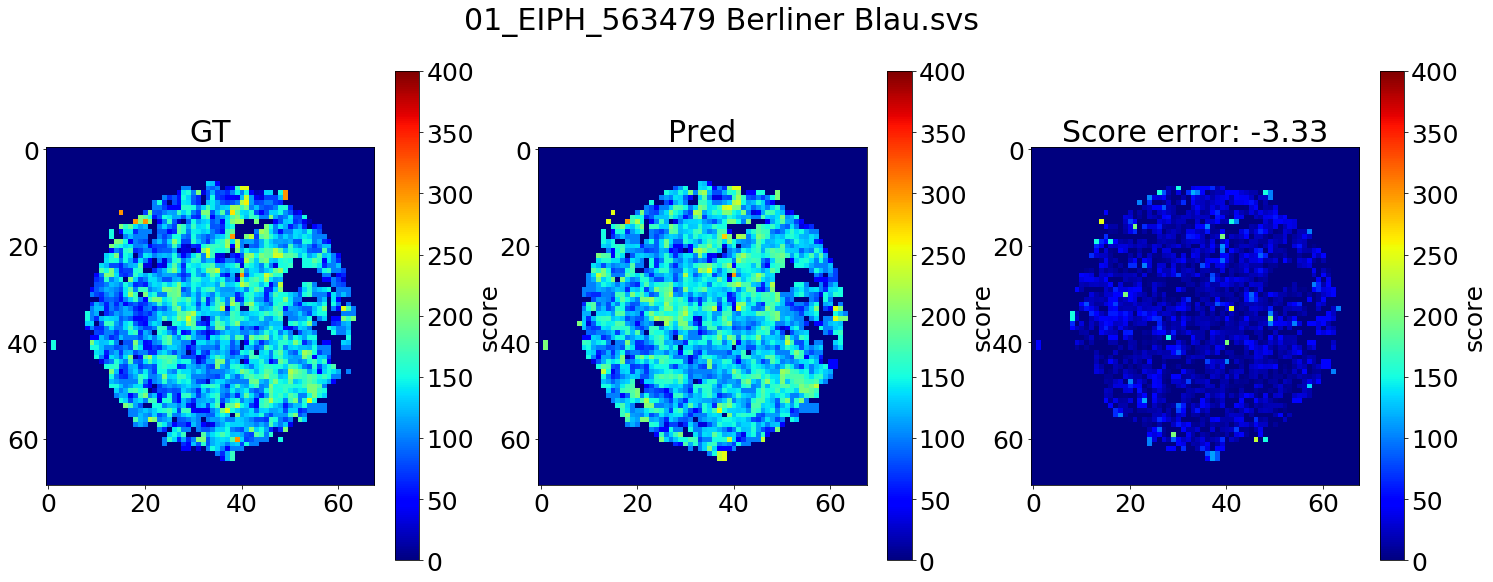

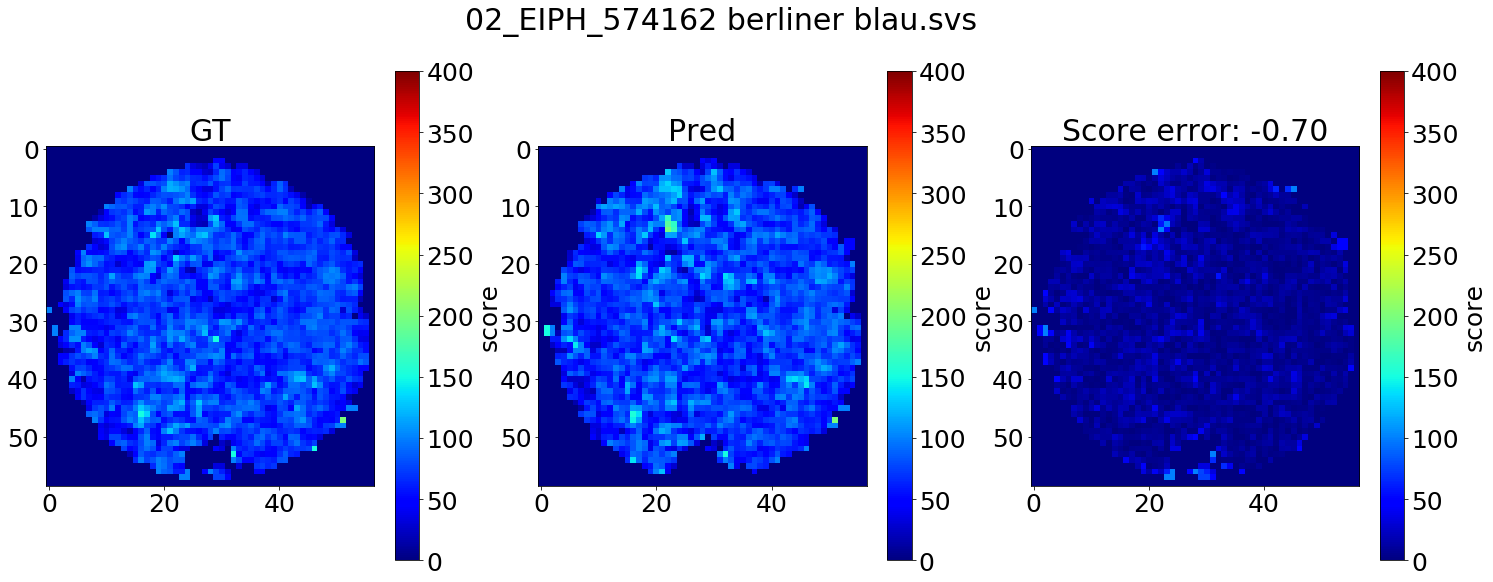

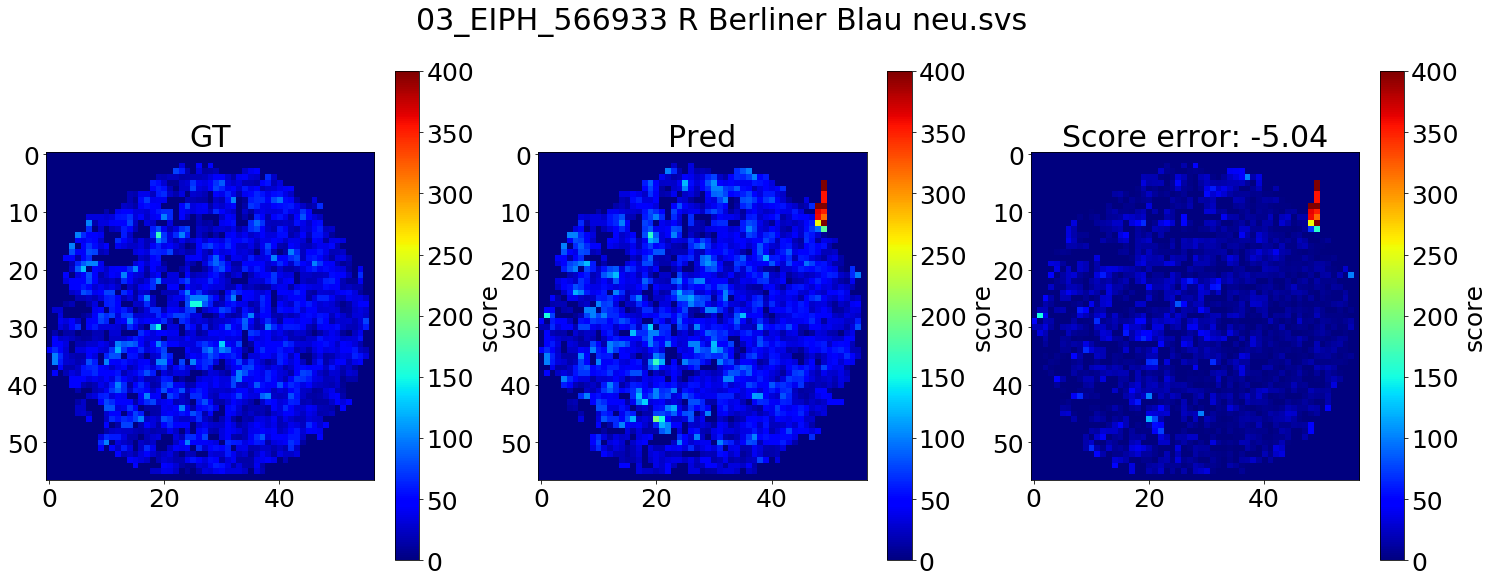

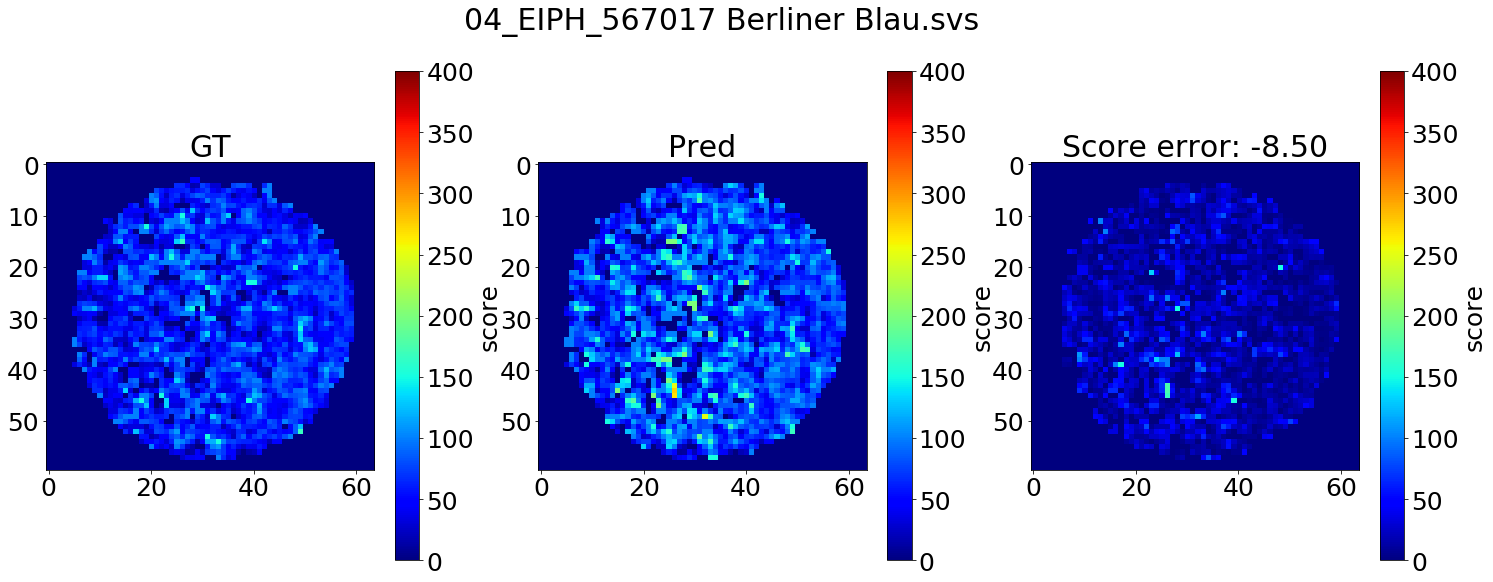

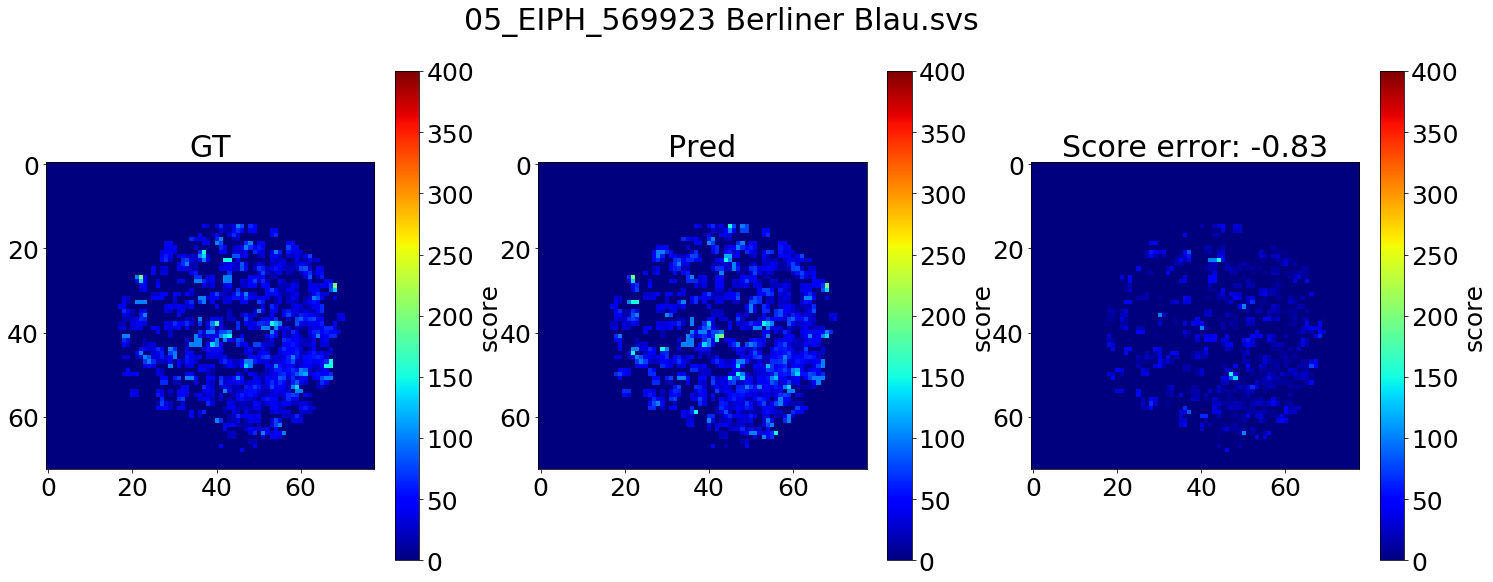

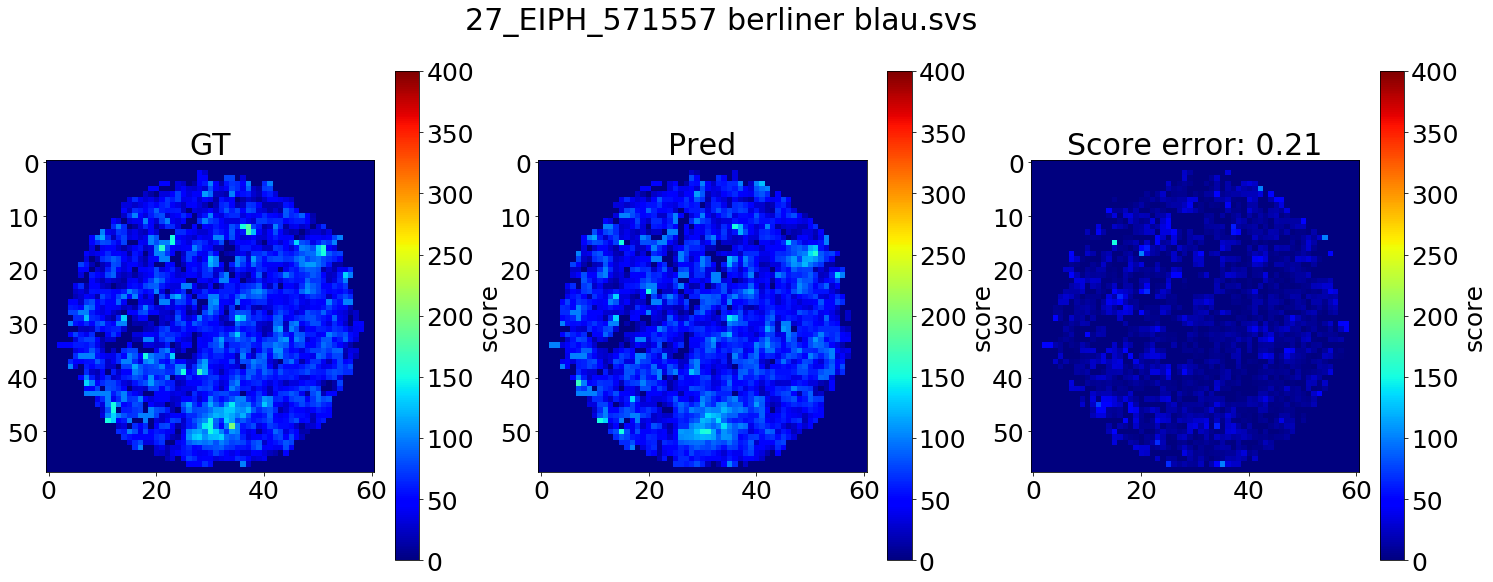

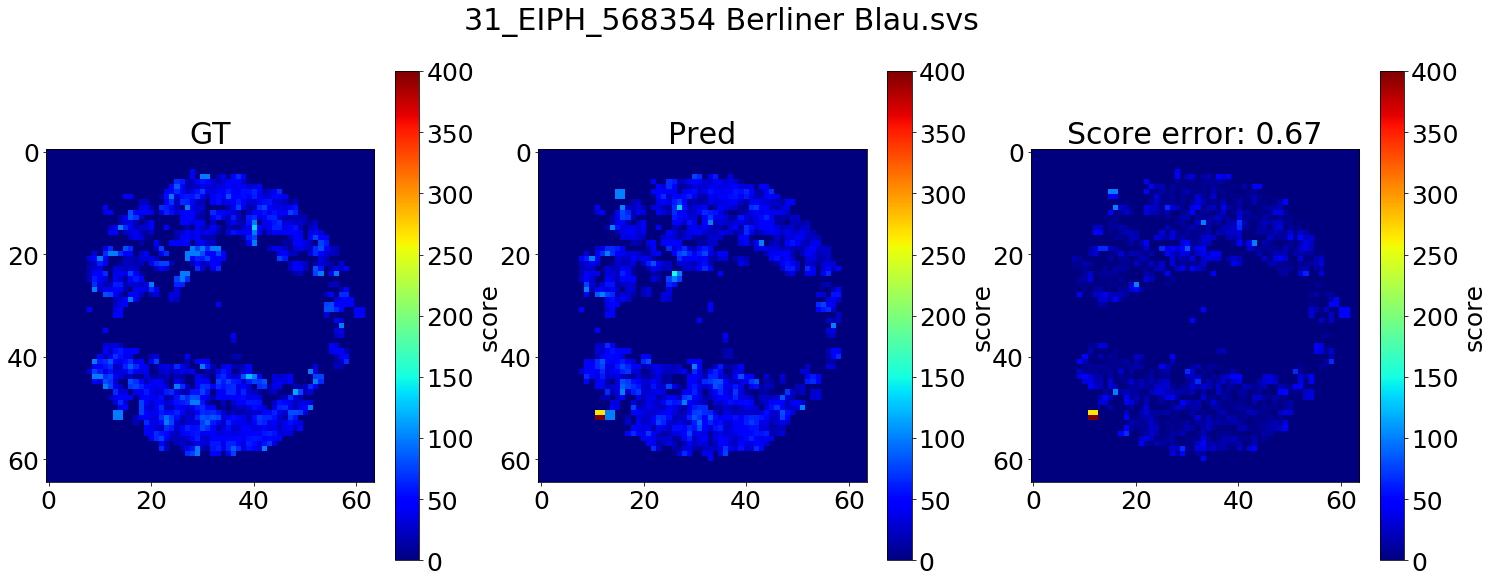

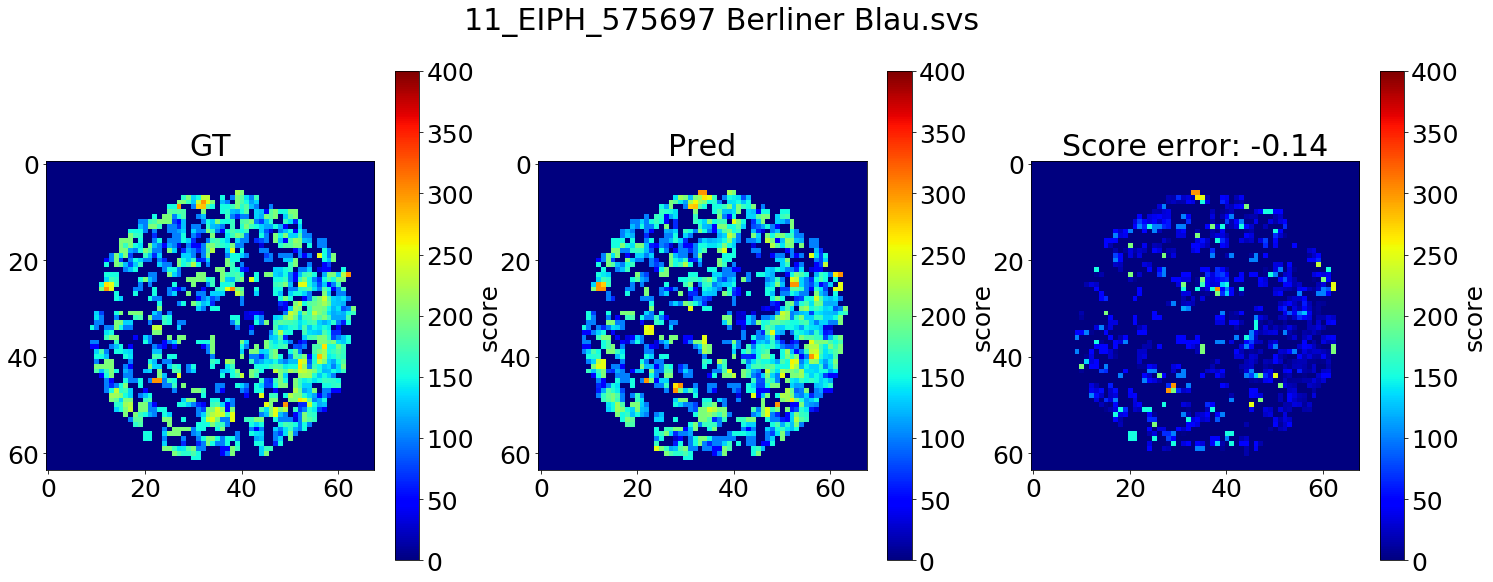

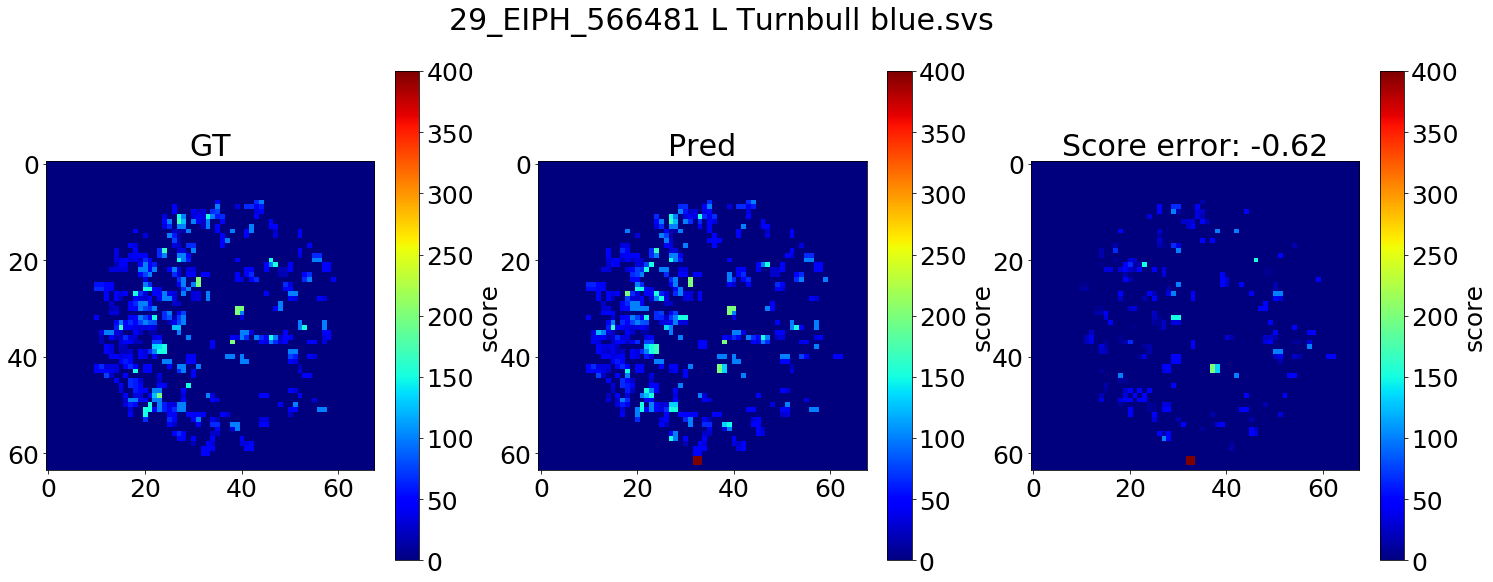

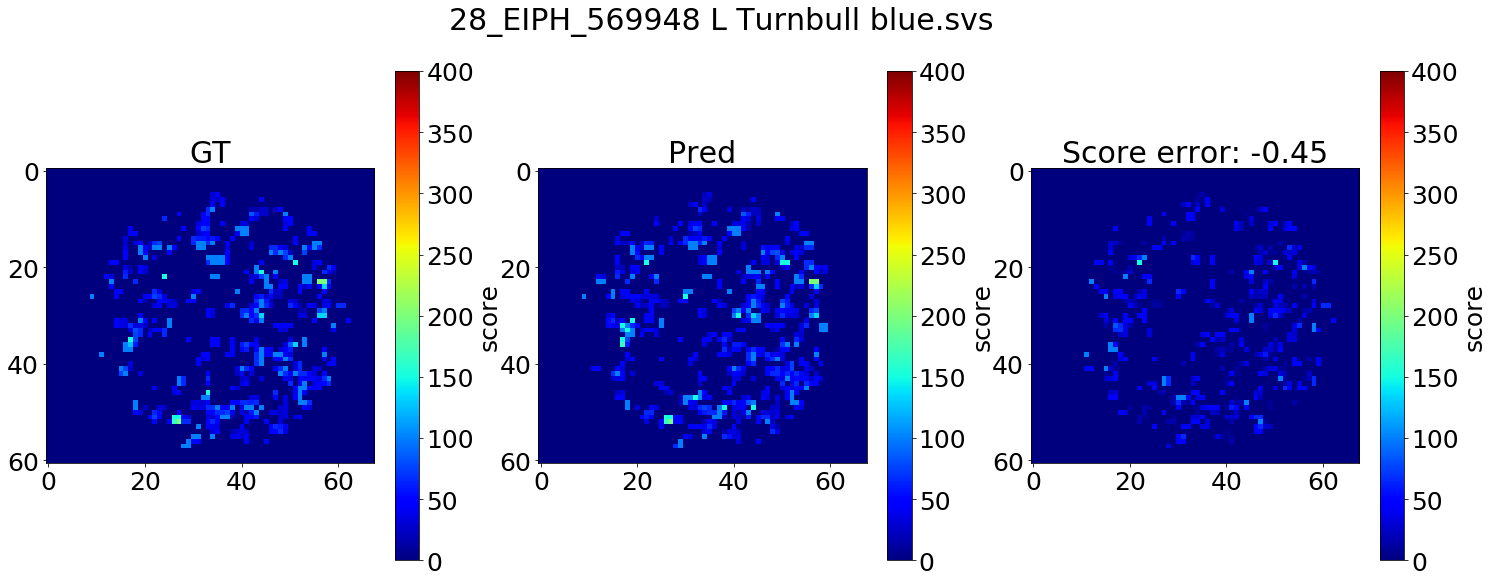

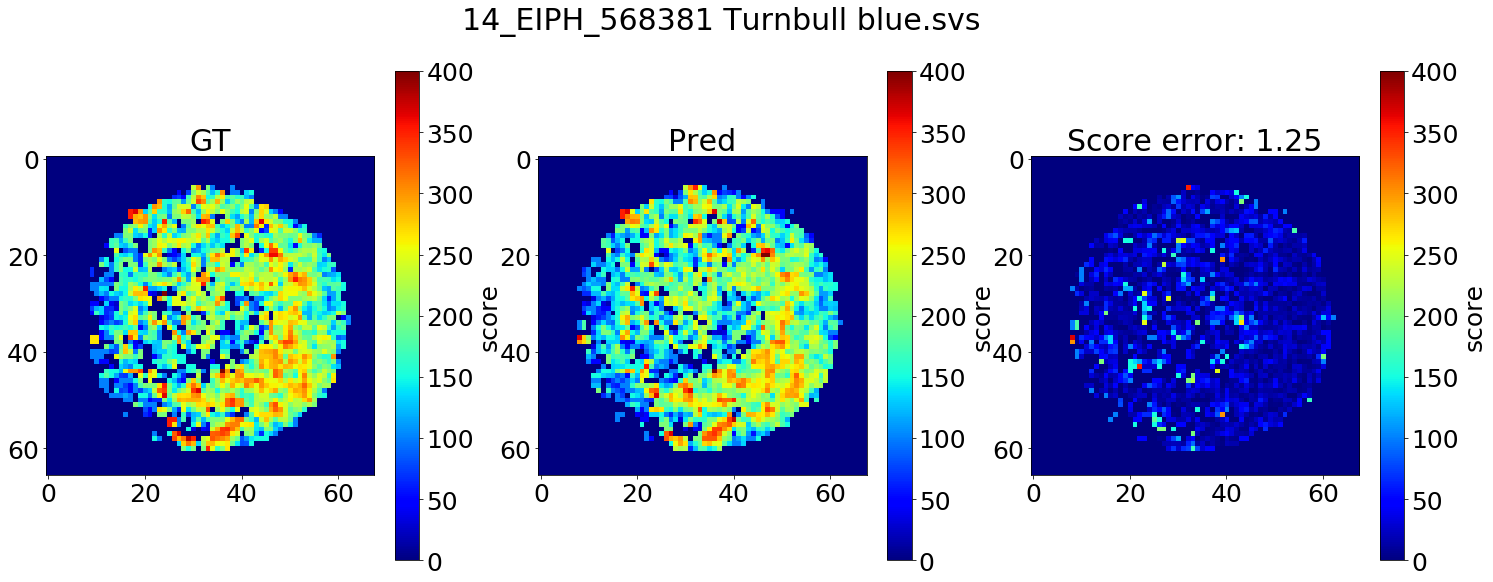

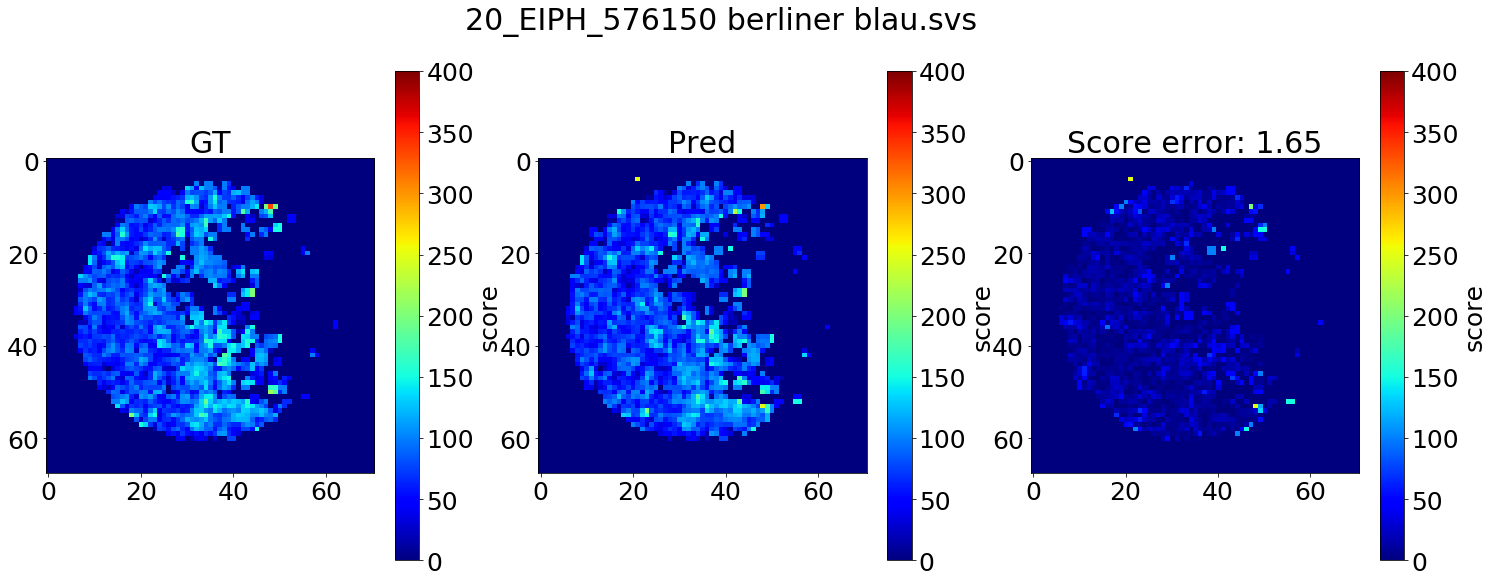

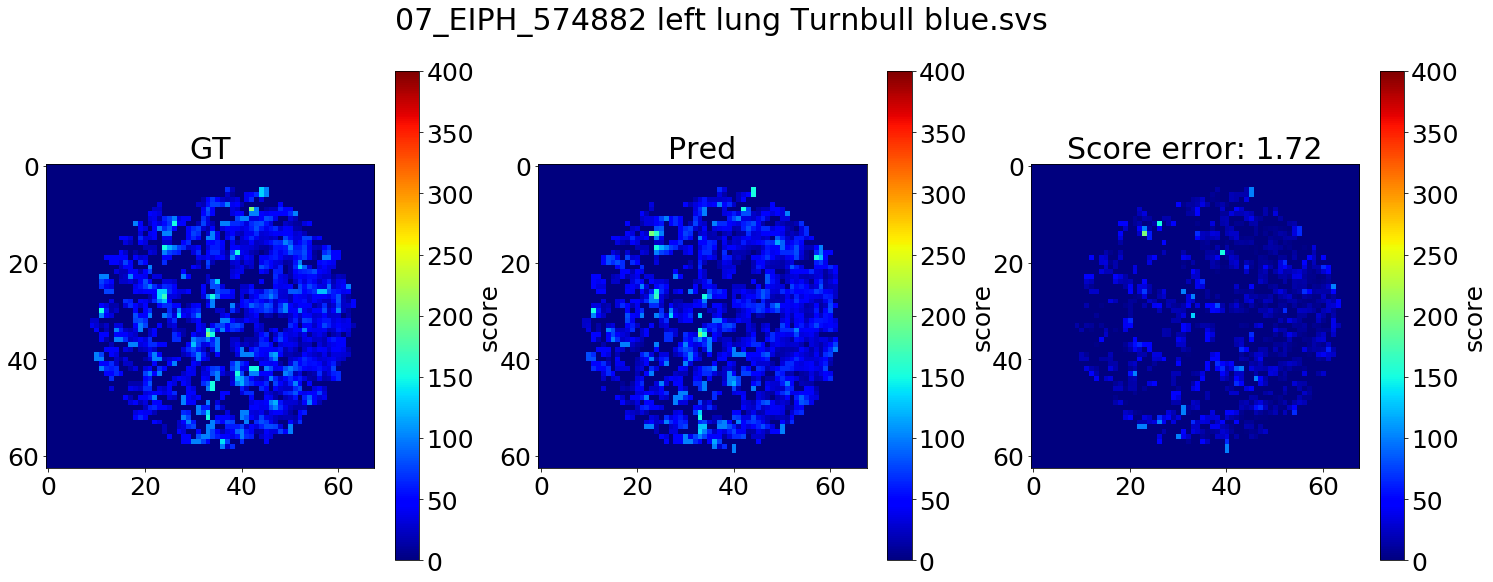

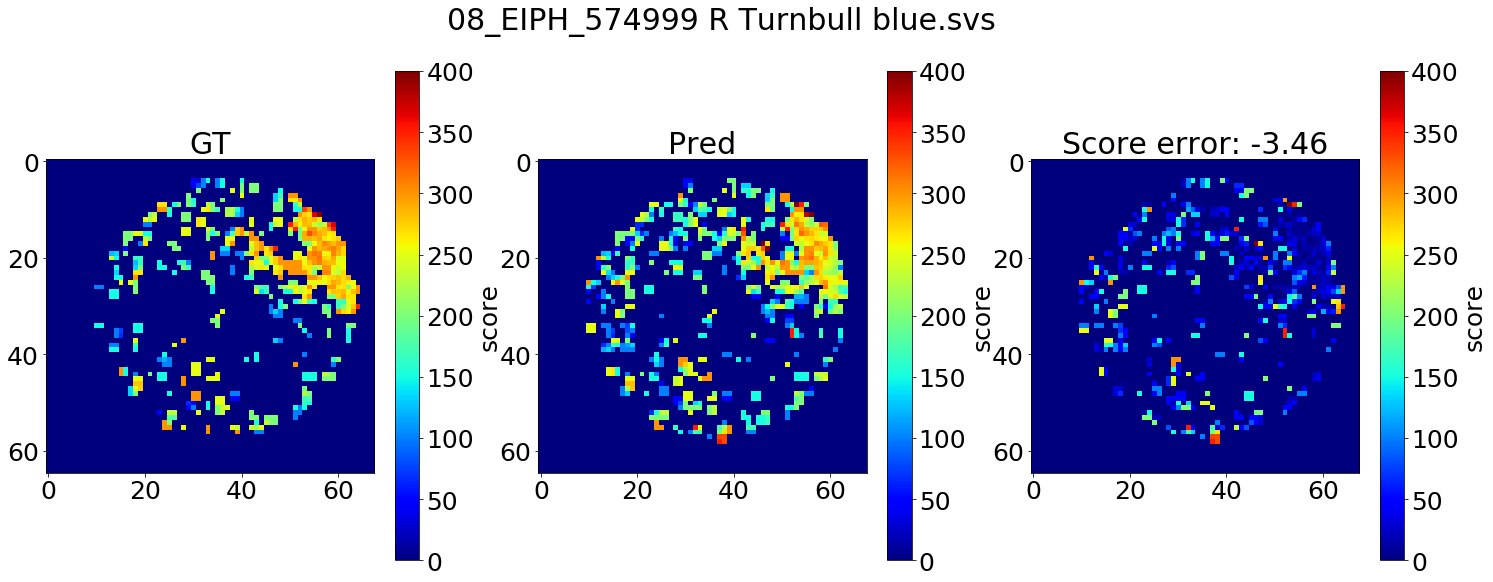

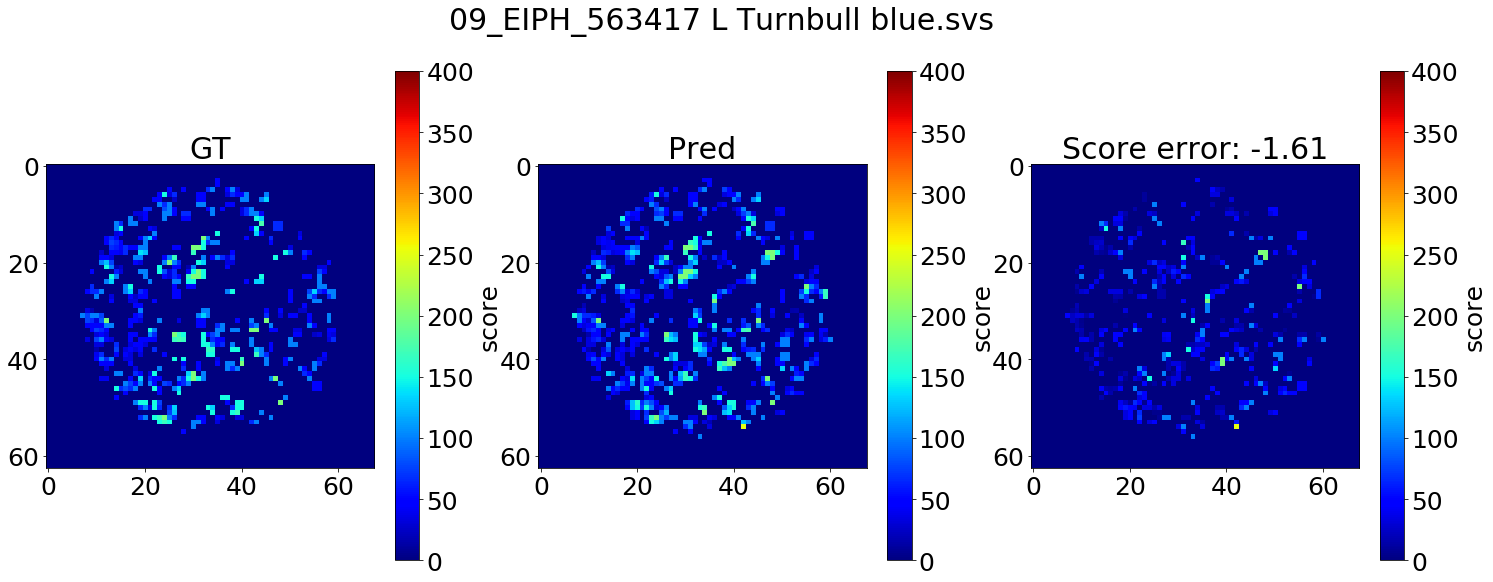

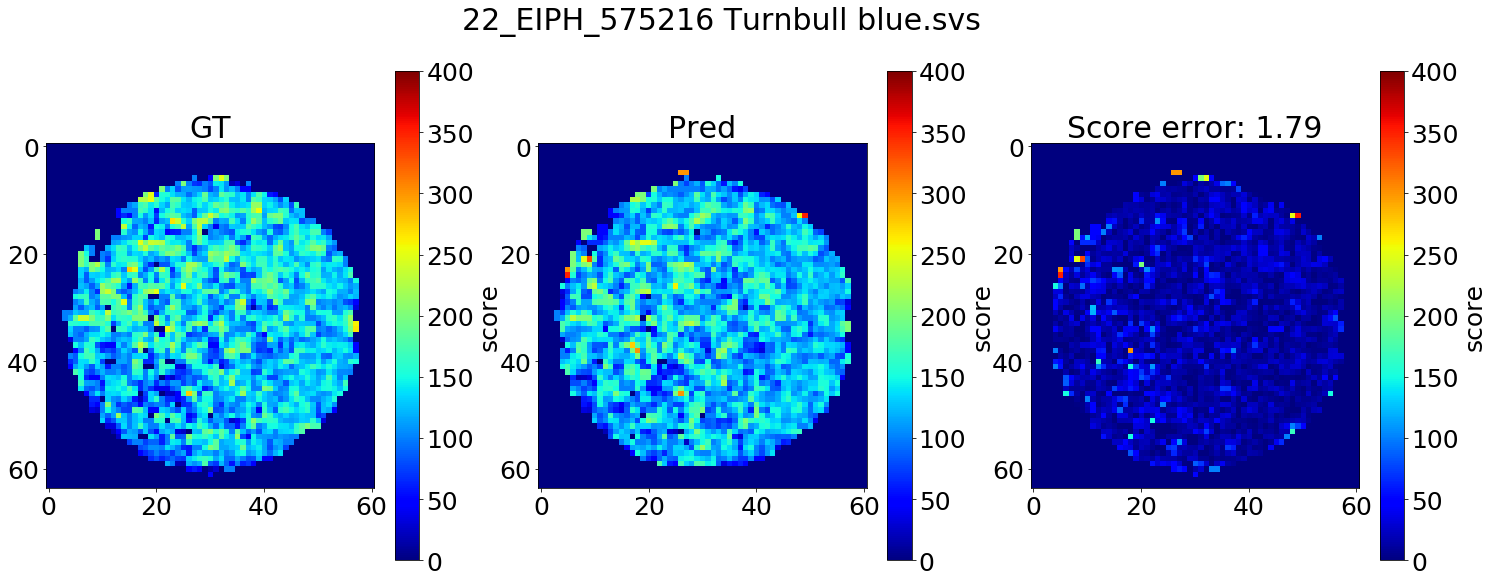

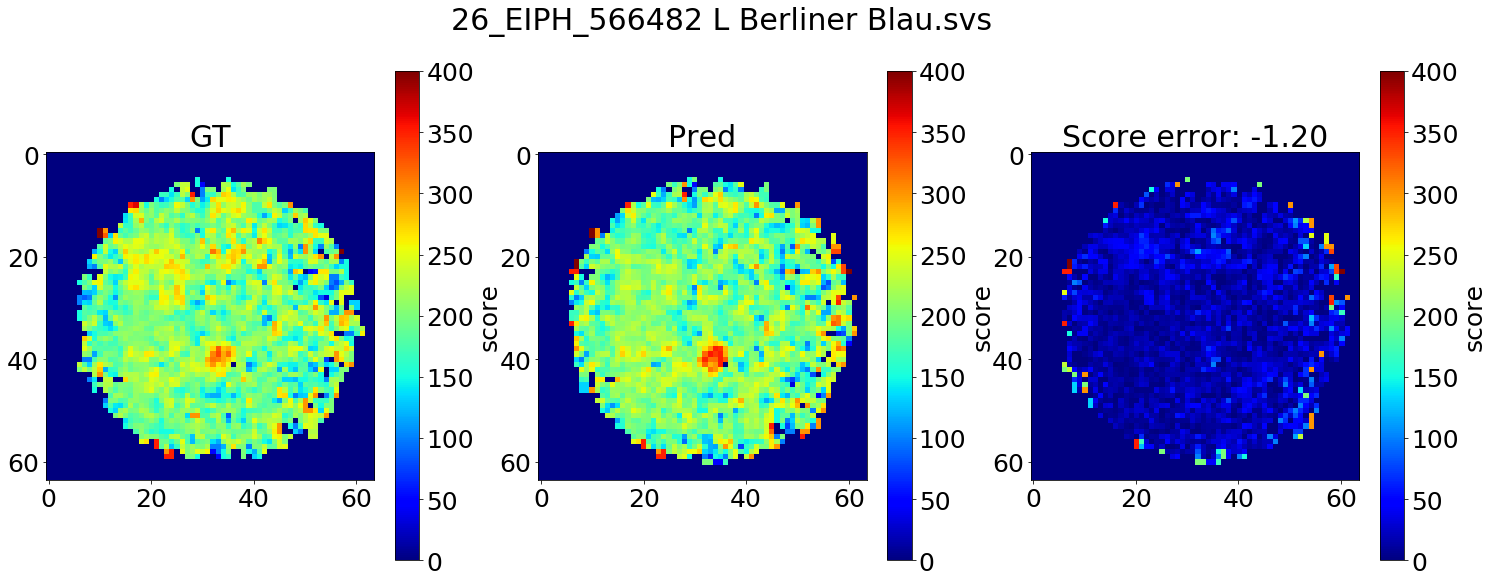

In [29]:
#plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 25

for file in files:
    pred_image = prediction[file.file.name] * 100
    gt_image = gt[file.file.name] * 100
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(25, 9))
    fig.suptitle(file.file.name) #, fontsize=16

    diff = np.mean(gt_image - pred_image)
    ax[0].set_title('GT')
    ax[1].set_title('Pred')
    ax[2].set_title('Score error: {0:.2f}'.format(float(diff)))
    
    max_value = 400#np.max(gt_image)
    cset0 = ax[0].imshow(gt_image,  cmap=cm.jet, vmin=0, vmax=max_value)
    cset1 = ax[1].imshow(pred_image,  cmap=cm.jet, vmin=0, vmax=max_value)
    cset2 = ax[2].imshow(np.abs(pred_image-gt_image),  cmap=cm.jet, vmin=0, vmax=max_value)
    
    fig.colorbar(cset0, ax=ax[0], label='score')
    fig.colorbar(cset1, ax=ax[1], label='score')
    fig.colorbar(cset2, ax=ax[2], label='score')
    
    fig.savefig(file.file.stem+".eps", transparent=True)

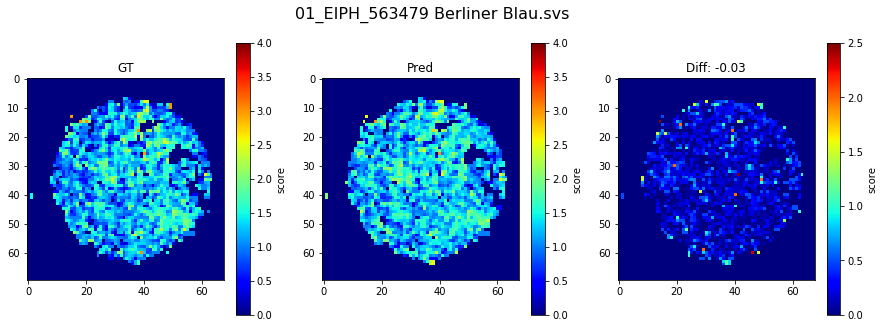

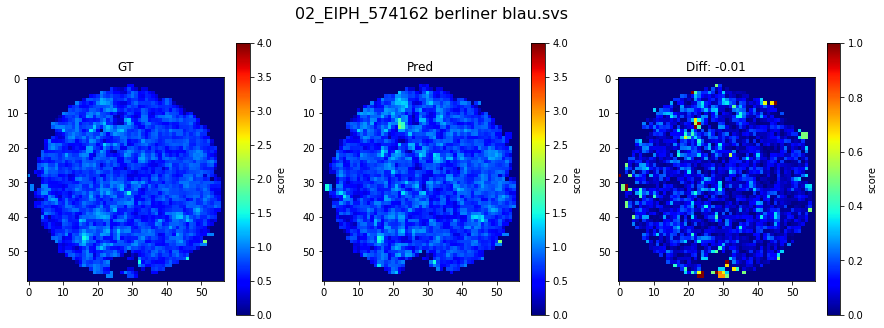

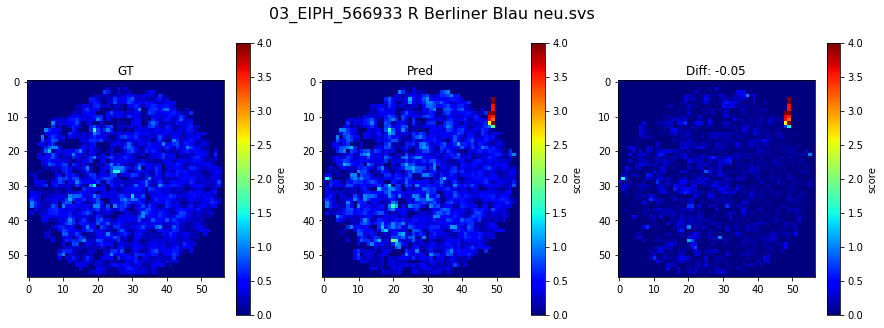

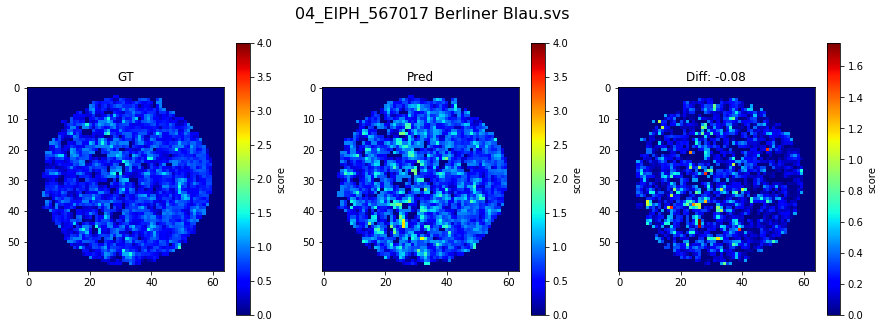

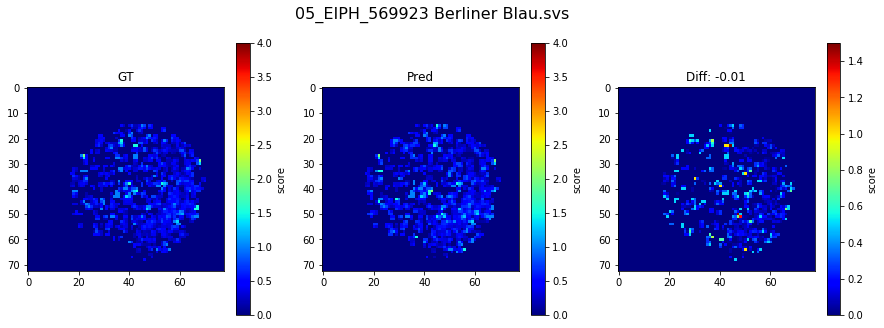

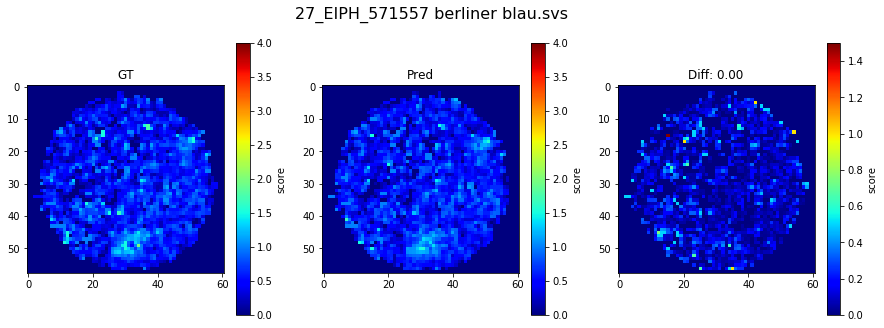

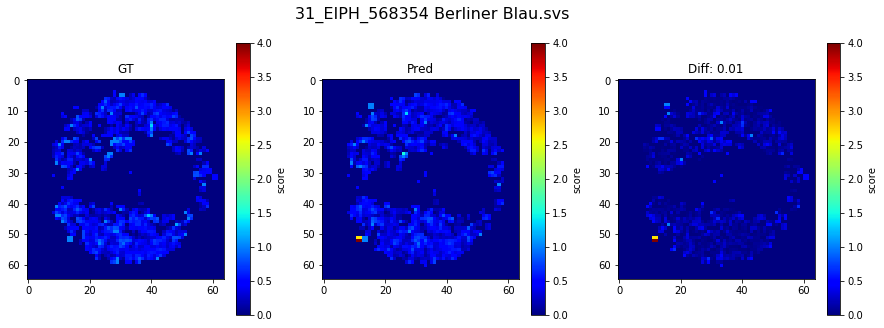

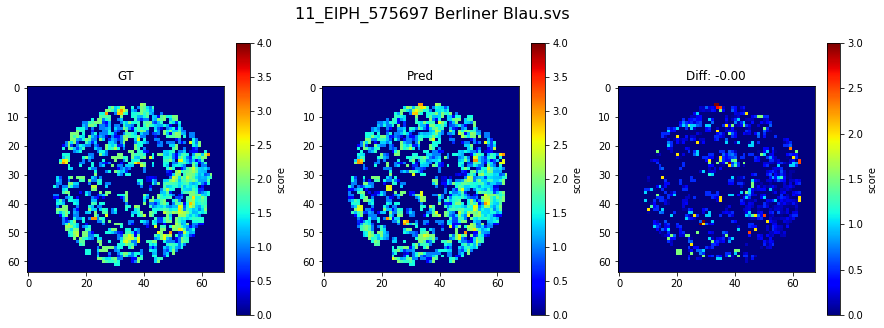

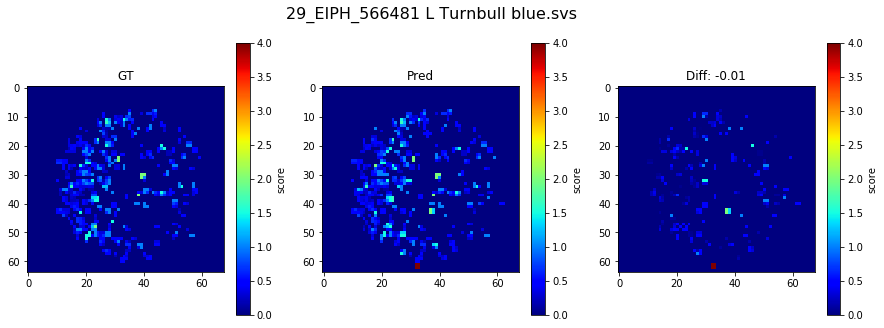

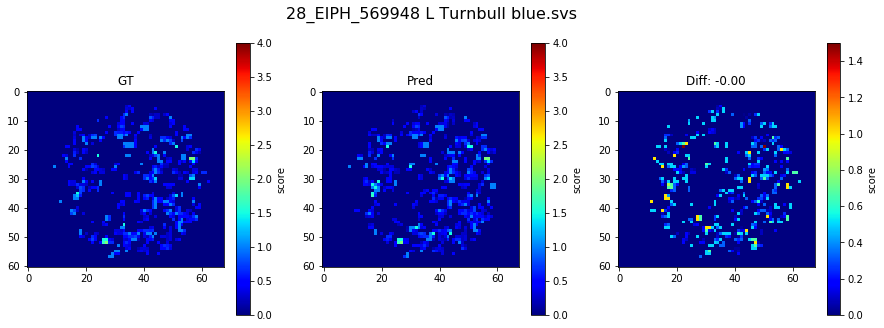

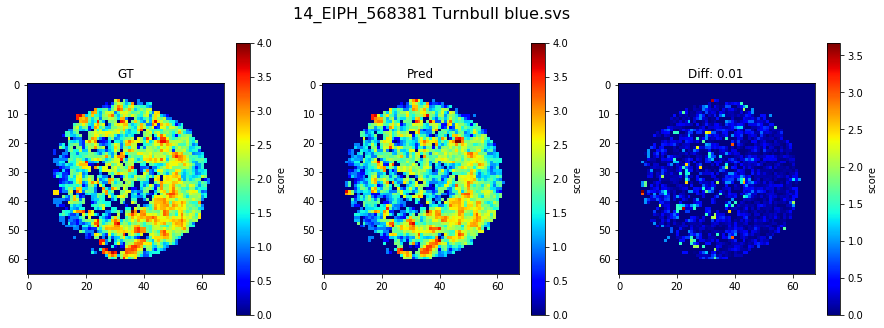

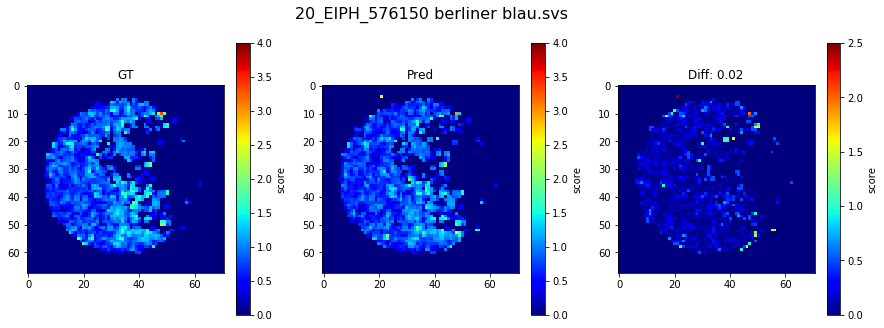

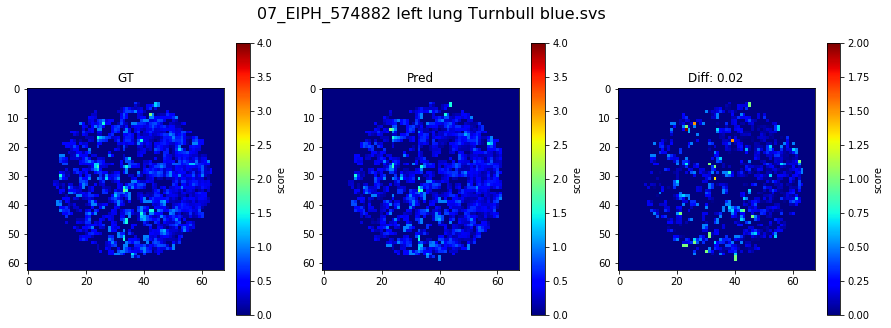

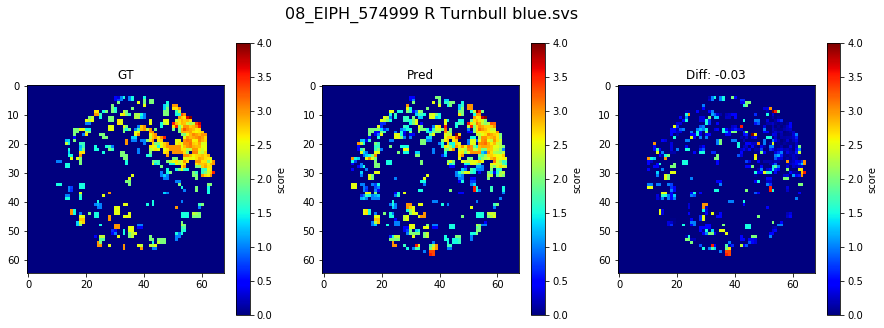

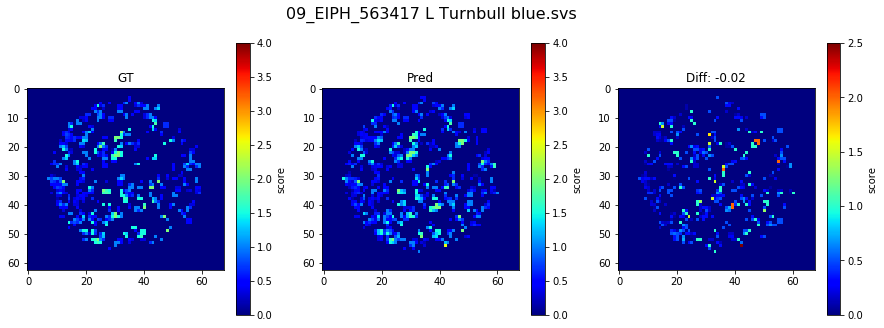

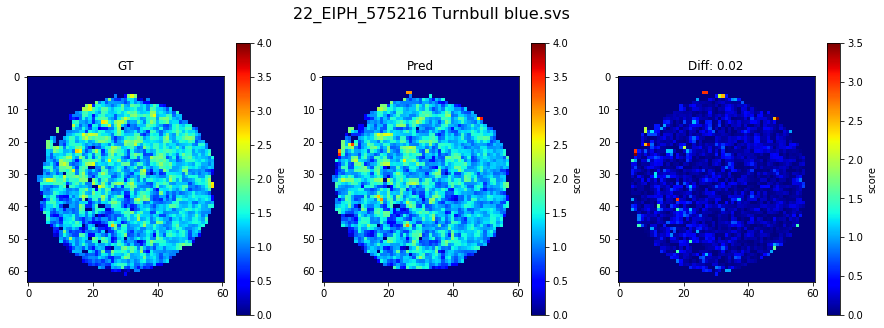

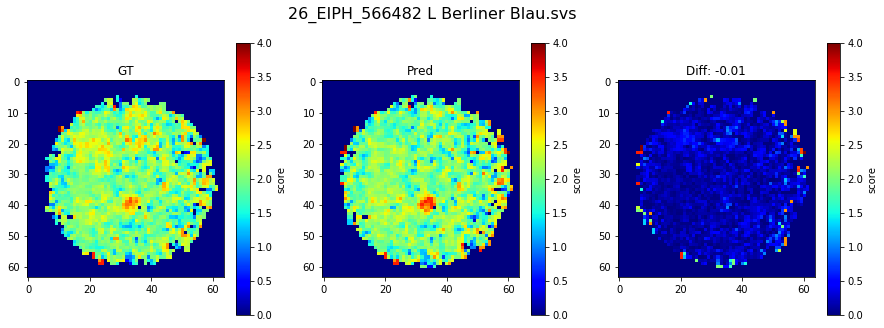

In [21]:
for file in files:
    pred_image = prediction[file.file.name] * 100
    gt_image = gt[file.file.name] * 100
    
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    fig.suptitle(file.file.name, fontsize=16)

    diff = np.mean(gt_image - pred_image)
    ax[0].set_title('GT')
    ax[1].set_title('Pred')
    ax[2].set_title('Score error: {0:.2f}'.format(float(diff)))
    
    max_value = 400#np.max(gt_image)
    cset0 = ax[0].imshow(gt_image,  cmap=cm.jet, vmin=0, vmax=max_value)
    cset1 = ax[1].imshow(pred_image,  cmap=cm.jet, vmin=0, vmax=max_value)
    cset2 = ax[2].imshow(np.abs(pred_image-gt_image),  cmap=cm.jet, vmax=max_value) # vmin=0, 
    
    fig.colorbar(cset0, ax=ax[0], label='score')
    fig.colorbar(cset1, ax=ax[1], label='score')
    fig.colorbar(cset2, ax=ax[2], label='score')
    
    fig.savefig(file.file.stem+".eps", transparent=True)